This notebook demonstrates how to use the Geometric Model. 

In [2]:
import os

import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy.optimize import minimize
from scipy.stats import norm
import math
import matplotlib.pyplot as plt
from scipy import stats
import scipy.special as sc
from scipy.special import beta

In [4]:
filename = 'C:/Users/User/OneDrive/Desktop/github-repo-folder/adv_bus_analytics/homework_2/retention_data_geometricmodel-1 (1).xlsx'
data_in = pd.read_excel(filename, usecols='A:D')

In [5]:
data_in = data_in.rename(columns={'# Customers':'Customers', '% Alive':'Alive', 'retention rate':'retention'})

In [7]:
print(data_in)

    Year  Customers  Alive  retention
0      0       1000  1.000        NaN
1      1        631  0.631   0.631000
2      2        468  0.468   0.741680
3      3        382  0.382   0.816239
4      4        326  0.326   0.853403
5      5        289  0.289   0.886503
6      6        262  0.262   0.906574
7      7        241  0.241   0.919847
8      8        223  0.223   0.925311
9      9        207  0.207   0.928251
10    10        194  0.194   0.937198
11    11        183  0.183   0.943299
12    12        173  0.173   0.945355


Plot retention rate. It is just 1 - hazard.

Text(0, 0.5, 'Retention Rate')

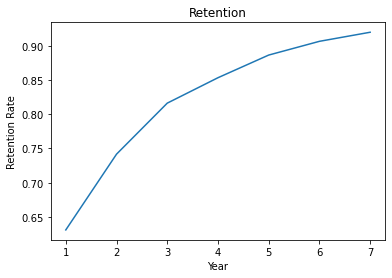

In [42]:
plt.plot(data_in[0:8].Year, data_in[0:8].retention)
plt.title('Retention')
plt.xlabel('Year')
plt.ylabel('Retention Rate')

Plot the hazard.

Text(0, 0.5, 'Hazard Rate')

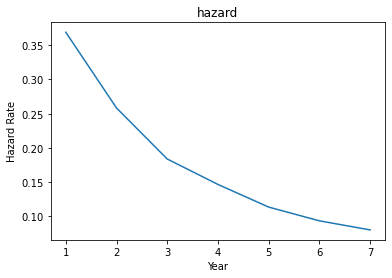

In [43]:
data_in['hazard'] = 1 - data_in.retention
plt.plot(data_in[0:8].Year, data_in[0:8].hazard)
plt.title('hazard')
plt.xlabel('Year')
plt.ylabel('Hazard Rate')

In [44]:
data_in['hazard'] = 1 - data_in.retention
data_in.head()

,Year,Customers,Alive,retention,hazard
0,0,1000,1.000,NaN,NaN
1,1,631,0.631,0.631000,0.369000
2,2,468,0.468,0.741680,0.258320
3,3,382,0.382,0.816239,0.183761
4,4,326,0.326,0.853403,0.146597


Plot the churn rate.

Text(0, 0.5, 'Customers')

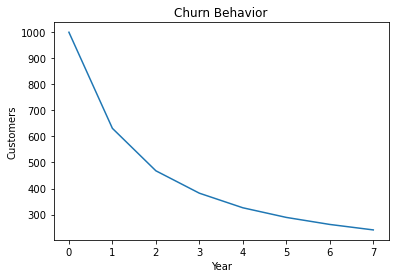

In [45]:
plt.plot(data_in[0:8].Year, data_in[0:8].Customers)
plt.title('Churn Behavior')
plt.xlabel('Year')
plt.ylabel('Customers')

First try the simplest fit - an OLS with respect to time.

In [46]:
X = sm.add_constant(data_in.Year)
y = data_in[1:8].Alive
output = sm.OLS(y, X[1:8]).fit()
linear = output.predict(X[1:12])

C:\Users\rston\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Try some other simple variations of the least squares fit.

Take log of time

In [47]:
#data_in['logtime'] = np.log(data_in.Year)
X = sm.add_constant(data_in.Year)
y = np.log(data_in[1:8].Alive)
output = sm.OLS(y, X[1:8]).fit()
loglinear = np.exp(output.predict(X[1:12]))

Take square of time

In [48]:
data_in['year2'] = data_in.Year**2
X = np.transpose((data_in.Year, data_in.year2))
X = sm.add_constant(X)
y = data_in[1:8].Alive
output = sm.OLS(y, X[1:8]).fit()
square = output.predict(X[1:12])

Now plot the predictions of linear, square, and loglinear regression and see the fit. The red line is the input data.

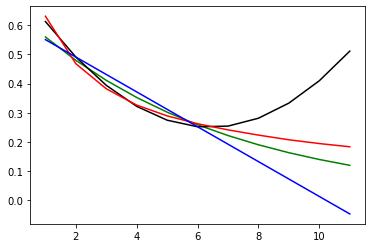

In [49]:
plt.plot(data_in.Year[1:12], loglinear, color='green', label='exponential')
plt.plot(data_in.Year[1:12], square, color='black', label='square')
plt.plot(data_in.Year[1:12], data_in.Alive[1:12], color='red', label='Data')
plt.plot(data_in.Year[1:12], linear, color='blue', label='linear')


The loglinear model does the best job, but none is truly satisfactory. Moreoever, these models do OK with in sample data (up to t=7) but start doing poorly with new (later) data.

A better solution is to use the geometric model.

Now create a column with how many people churn every year

In [51]:
data_in['lost'] = 1
for i in range(0,7):
    data_in.loc[i+1, 'lost'] = data_in.Customers[i] - data_in.Customers[i+1]

In [1]:
print(data_in)

NameError: name 'data_in' is not defined

In [53]:
# Geometric model - we take the first 8 rows
data1 = data_in[0:8].copy()

def MLE_Geo(params):

    theta1 = params

    L = [None] * 8

    # We ignore the first entry which is year=0 and start from year=1
    # these users are churning until year 7
    L[0:7] = np.log(theta1 * (1-theta1)**((data1.Year[1:8]) - 1)) * data1.lost[1:8]

    # For the last year, year 8, there is no churn. These are the remaining
    # users who might churn in the future.
    # Now we have to accomodate their survival probability
    L[7:8] = np.log((1 - theta1)**((data1.Year[7:8])))*data1.Customers[7:8]
    LL = -sum(L)
    return LL

We use Nelder-mead and define the bound to be between 0 and 1.

In [54]:
bounds = [(0, 1)]
mle_model = minimize(MLE_Geo, x0=0.1, method='Nelder-mead', options={'disp': True}, bounds=bounds)
mle_model

Optimization terminated successfully.
         Current function value: 1794.620857
         Iterations: 14
         Function evaluations: 28


 final_simplex: (array([[0.22601563],
       [0.22609375]]), array([1794.62085704, 1794.62089796]))
           fun: 1794.6208570402935
       message: 'Optimization terminated successfully.'
          nfev: 28
           nit: 14
        status: 0
       success: True
             x: array([0.22601563])

In [55]:
# recover the parameters
theta1 = mle_model.x

probability of churn every year

In [56]:
churn_prob = (theta1 * (1-theta1)**((data_in.Year[1:12]) - 1))

people remaining after 11 periods

In [57]:
remaining = 1 - sum(churn_prob[1:11])

We now append churn_prob with remaining users to calculate the numbers.

In [58]:
# probability of churning in time t
pred_churn = np.append(churn_prob, remaining)

Now we calculate how many remain after churning every time. 

In [59]:
# Predictions
pred_alive = [None]*12
pred_alive[0] = 1000
for i in range(1, 12):
    pred_alive[i] = pred_alive[i-1] - pred_churn[i-1]*1000

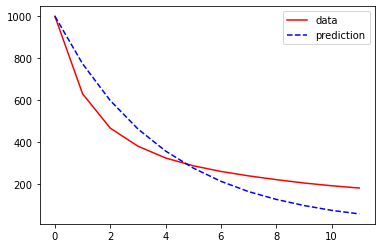

In [60]:
plt.plot(data_in.Year[0:12], data_in.Customers[0:12], color='red', label='data')
plt.plot(data_in.Year[0:12], np.round(pred_alive), '--',  color='blue', label='prediction')
plt.legend()
plt.show()

Calculate the BIC.

In [61]:
k = 1
pop_size = 1000
k * np.log(pop_size) - 2 * (-mle_model.fun)

3596.149469359569

Now we estimate 2 segments for the data.

In [62]:
def MLE_Geo_segment(params):
    theta1 = params[0]
    theta2 = params[1]
    p = params[2]
    L = [None]*8
    Prob = [None]*8

    # Due to 2 segments, we need to iterate over the loop.
    for i in range(0, 8):
        if i < 7:
            Prob1 = theta1 * (1 - theta1)**((data1.Year[i+1]) - 1)
            Prob2 = theta2 * (1 - theta2)**((data1.Year[i+1]) - 1)
            Prob[i] = p * Prob1 + (1-p) * Prob2
            L[i] = np.log(Prob[i])*data1.lost[i+1]
        else:
            Prob_surv = 1 - sum(Prob[0:7])
            L[i] = np.log(Prob_surv)*data1.Customers[i]

    LL = -sum(L)
    params
    return LL

In [63]:
bounds = [(0.001, 0.99), (0.001, 0.99), (0.001, 0.99)]
init = [0.2, 0.2, 0.2]
mle_model = minimize(MLE_Geo_segment, x0=init, method='Nelder-mead', options={'disp': True}, bounds=bounds)
mle_model

Optimization terminated successfully.
         Current function value: 1680.045549
         Iterations: 84
         Function evaluations: 147


 final_simplex: (array([[0.08303934, 0.58603404, 0.43941106],
       [0.08302016, 0.585951  , 0.43932445],
       [0.08300316, 0.58599213, 0.43933043],
       [0.08304625, 0.58609712, 0.43942389]]), array([1680.04554872, 1680.04554993, 1680.04555003, 1680.04555044]))
           fun: 1680.0455487209592
       message: 'Optimization terminated successfully.'
          nfev: 147
           nit: 84
        status: 0
       success: True
             x: array([0.08303934, 0.58603404, 0.43941106])

We use these parameters to make a prediction about how many people "survive" every period as they churn every period. We do the same as before except we have to account for both segments.

In [64]:
theta1 = mle_model.x[0]
theta2 = mle_model.x[1]
p = mle_model.x[2]
Prob1 = theta1 * (1 - theta1)**((data_in.Year[1:12]) - 1)
Prob2 = theta2 * (1 - theta2)**((data_in.Year[1:12]) - 1)
Prob = p * Prob1 + (1-p) * Prob2
Prob_surv = 1 - sum(Prob)

pred_alive = [None]*12
pred_alive[0] = 1000
Probb = np.append(Prob, Prob_surv)

# Prob_surv
for i in range(1, 12):
    pred_alive[i] = pred_alive[i-1] - Probb[i-1]*1000

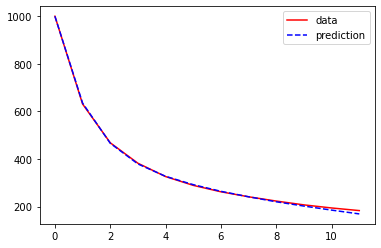

In [65]:
plt.plot(data_in.Year[0:12], data_in.Customers[0:12], color='red', label='data')
plt.plot(data_in.Year[0:12], np.round(pred_alive), '--',  color='blue', label='prediction')
plt.legend()
plt.show()

Calculate the BIC.

In [66]:
k = 3
pop_size = 1000
k * np.log(pop_size) - 2 * (-mle_model.fun)

3380.8143632788647

What if the heterogeneity is not discrete but continuous? Here we assume $g(\theta)$ follows a beta distribution. As before, we have to account for people who have not churned after 7 periods; this is in the "else" in the for loop.

In [67]:
def MLE_Geo_beta(params):
    alpha = params[0]
    betaa = params[1]

    L = [None]*8
    Prob = [None]*8

    for i in range(0, 8):
        if i < 7:
            Prob[i] = beta(alpha + 1, betaa + data1.Year[i+1] - 1)/beta(alpha, betaa)
            L[i] = np.log(Prob[i])*data1.lost[i+1]
        else:
            Prob_surv = 1 - sum(Prob[0:7])
            L[i] = np.log(Prob_surv)*data1.Customers[i]

    LL = -sum(L)
    params
    return LL

In [68]:
init = [1, 1]
bounds=[(0, 100), (0, 100)]
mle_model = minimize(MLE_Geo_beta, x0=init, method='Nelder-mead', options={'disp': True}, bounds=bounds)
mle_model

Optimization terminated successfully.
         Current function value: 1680.265188
         Iterations: 40
         Function evaluations: 76


 final_simplex: (array([[0.70408791, 1.18206402],
       [0.70406642, 1.18201387],
       [0.70407763, 1.18201229]]), array([1680.26518848, 1680.26518848, 1680.26518856]))
           fun: 1680.2651884764566
       message: 'Optimization terminated successfully.'
          nfev: 76
           nit: 40
        status: 0
       success: True
             x: array([0.70408791, 1.18206402])

In [69]:
# extracting parameters to make predictions
alpha = mle_model.x[0]
betaa = mle_model.x[1]

Prob1 = [None]*12

for i in range(0, 12):
    if i < 12:
        Prob1[i] = beta(alpha + 1, betaa + data_in.Year[i+1] - 1)/beta(alpha, betaa)
    else:
        Prob_surv = 1 - sum(Prob1[0:11])
        Prob1[i] = Prob_surv

pred_alive = [None]*12
pred_alive[0] = 1000

for i in range(1, 12):
    pred_alive[i] = pred_alive[i-1] - Prob1[i-1]*1000

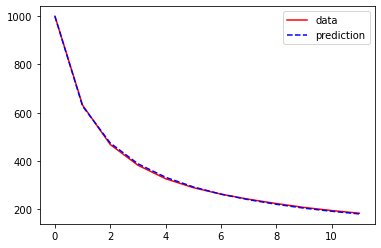

In [70]:
plt.plot(data_in.Year[0:12], data_in.Customers[0:12], color='red', label='data')
plt.plot(data_in.Year[0:12], np.round(pred_alive), '--',  color='blue', label='prediction')
plt.legend()
plt.show()

Calculate the BIC.

In [71]:
k = 2
pop_size = 1000
k * np.log(pop_size) - 2 * (-mle_model.fun)

3374.3458875108777